# A Script to Compute the Relative Entropy Rate between the Observations of Two Linear Systems 
(Second version)

In [ ]:
import numpy as np
import scipy.linalg as la
import linalg_helpers as la_help
import control as ct
import compute_cov_inv as cov
import matplotlib.pyplot as plt

In [2]:
def generate_random_A(nx, W, type="gauss", cond_num_threshold=np.Inf):
    cond_num = np.Inf
    while cond_num >= cond_num_threshold:
        if type == "gauss":
            A = np.sqrt(0.33)*np.random.randn(nx, nx)
            max_eig = np.max(np.abs(la.eigvals(A)))
            A = 0.95*A / max_eig
        elif type == "upptri":
            A = np.diag(np.random.uniform(-1, 1, nx)) * 0.95
            A[np.triu_indices(nx, 1)] = np.random.uniform(-1, 1, (nx ** 2 + nx) // 2 - nx)

        
        Pi = ct.dlyap(A, W).astype(np.float64)
        cond_num = np.linalg.cond(Pi)
    print("cond_num of Pi: ", cond_num)

    return A.astype(np.float64), Pi

def generate_random_C(nx, ny):
    C = np.sqrt(0.333333333)*np.random.randn(ny, nx)
    return C.astype(np.float64)

In [ ]:
nx = 10
ny = 5
noise_std = 1e-1

context = 10


# C = generate_random_C(nx, ny)
C = np.block([np.eye(ny), np.zeros((ny, nx-ny))]).astype(np.float64) # observable
V = noise_std*np.eye(ny).astype(np.float64)
W = noise_std*np.eye(nx).astype(np.float64)



In [5]:
A,Pi = generate_random_A(nx, W)
Ap,Pi_p = generate_random_A(nx, W, type="gauss")

cond_num of Pi:  29.7731221063194
cond_num of Pi:  26.17884455907315


In [6]:
print("cond num of CPiC^T + V: ", np.linalg.cond(C @ Pi @ C.T + V))
print("cond num of CPi_pC^T + V: ", np.linalg.cond(C @ Pi_p @ C.T + V))

cond num of CPiC^T + V:  13.689602993540412
cond num of CPi_pC^T + V:  25.039502101253714


In [8]:
Kn, Kinvs, Finvs = cov.compute_cov_inv(A,C,V,Pi, context)
Kn_p, Kinvs_p, Finvs_p = cov.compute_cov_inv(Ap,C,V,Pi_p, context)

ran for context: 10
Matrix K_k @ K_k^inv:
    1.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000 
   -0.0000     1.0000     0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000 

# compute rel ent rate function

(using natural log)

In [9]:
def F_k(Kinv, ny):
    return Kinv[:ny, :ny]

def G_k(Kinv, ny):
    return Kinv[:ny, ny:]

In [10]:
rel_ent = []
print("len(finvs): ", len(Finvs))

for k in range(context):

    Gk = G_k(Kinvs[k], ny)
    Gpk = G_k(Kinvs_p[k], ny)
    Fk = F_k(Kinvs[k], ny)
    Fpk = F_k(Kinvs_p[k], ny)
    if k ==0:
        K0 = cov.K_k(Kn,ny,0)
        K0_p = cov.K_k(Kn_p,ny,0)
        
        rel_ent.append(0.5*(np.log(la.det(K0_p)) - np.log(la.det(K0)) + np.trace(Kinvs_p[k]@K0 - np.eye(ny)))) #from Polyanskiy and Wu Ex. 2.2 (non conditional relative entropy between two multivariate gaussians)
    else:
        rel_ent.append(rel_ent[k-1] + 0.5*(np.log(((2*np.pi)**(2*ny))*((np.e)**ny)*la.det(Finvs[k])*la.det(Finvs_p[k])) + np.trace(Finvs[k]@Fpk) + np.trace(Gpk.T@(Finvs_p[k]@Gpk - 2*Finvs[k]@Gk )@Kinvs[k-1] ))    )

print("rel_ent: ", rel_ent)
rel_ent_rates = [x / y for x, y in zip(rel_ent, range(1, len(rel_ent) + 1))]

len(finvs):  10
rel_ent:  [4.005709014797494, 23.082283320437796, 39.983186393849515, 56.572826403850726, 73.39458426102618, 90.20642776513567, 107.07139918295945, 123.94481854970074, 140.81729933165502, 157.68888015492496]


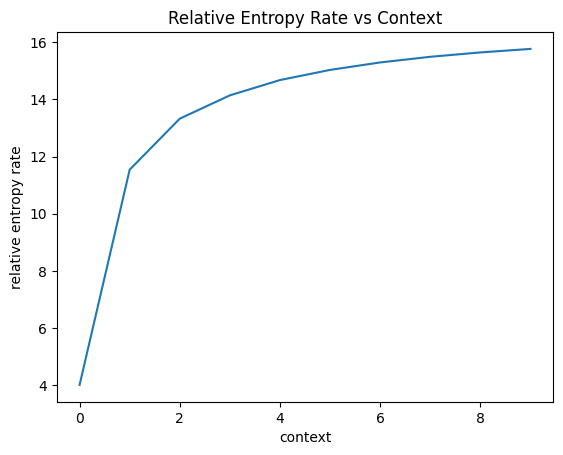

In [11]:
#plot the relative entropy rate vs the context

plt.plot(range(context), rel_ent_rates)
plt.xlabel("context")
plt.ylabel("relative entropy rate")
plt.title("Relative Entropy Rate vs Context")
plt.show()

Compute the powers of $A$ and the first row of $K_N$

In [60]:
A_powers = la_help.compute_powers(A, context)

values = C@A_powers@Pi@C.T
for i in range(context):
    la_help.print_matrix(values[i], f"C A^{i} Π C^T")

# values = la_help.lower_threshold_matrix(values, 1e-5)
# for i in range(context):
#     la_help.print_matrix(values[i], f"C A^{i} Π C^T thresholded")

AttributeError: module 'linalg_helpers' has no attribute 'compute_powers'

Compute $K_N$

In [51]:
Kn = la_help.block_toeplitz(values) + la_help.create_repeated_block_diagonal(V, context)
print("shape of Kn: ", Kn.shape)

shape of Kn:  (50, 50)




Let $K_k^{-1} = \begin{bmatrix}
    F_k & G_k\\
    G_k^T & H_k
\end{bmatrix}$.

### Computing the Block Inverse Matrices
Let us give the off-diagonal blocks of $K_k$ the name $K_{off}$. This means, $K_k \triangleq \begin{bmatrix}
    K_{0} & K_{off}\\
    K_{off}^T & K_{k-1}
\end{bmatrix}$.
\begin{align}
    &K_k K_k^{-1} = I\\ 
    &\Rightarrow K_0 F_k + K_{off} G_k^T = I; \,\, K_{off}^T G_k + K_{k-1} H_k = I; \,\, K_0 G_k + K_{off} H_k = \mathbf{0}; \,\, \text{and } K_{off}^T F_k + K_{k-1} G_k^T = \mathbf{0}\\
    &\Rightarrow F_k = \left(K_0 - K_{off}K_{k-1}^{-1}K_{off}^T\right)^{-1}; \\ 
    &G_k = -F_k K_{off}K_{k-1}^{-1};\\
    &\text{and } H_k = K_{k-1}^{-1}\left(I - K_{off}^T G_k\right).
\end{align}

#### Remark
$F_k^{-1} = K_0 - K_{off}K_{k-1}^{-1}K_{off}^T$ requires no extra inverse because $K_{k-1}^{-1}$ is computed on the previous iteration. Furthermore $F_k^{-1} \in \R{m\times m}$ always, so computing $F_k$ only requires the inversion of a small matrix compared to the dimension of $K_k$.

Compute $F_k^{-1}$, $G_k^{-1}$, and $K_k^{-1}$ for all $k$.

In [30]:
def K_k(Kn, k):
    # The k-th Covariance matrix for the observation process
    return Kn[-ny*(k+1):, -ny*(k+1):]

In [52]:
print("eigvals of K0:", abs(la.eigvals(C@Pi@C.T + V)))
print("eigvals of Pi:", abs(la.eigvals(Pi)))

eigvals of K0: [1.7288974  0.28881186 0.43538825 0.8025     0.76926803]
eigvals of Pi: [1.34967128 0.41611701 0.26497633 0.16979608 0.15427598 0.12513894
 0.10000592 0.1047625  0.11146293 0.1092621 ]


In [55]:
Kinvs = []
Finvs = []
for k in range(context):
    if k == 0:
        Kinvs.append(la.inv(K_k(Kn, 0)))
    else:
        # la_help.print_matrix(K_k(Kn,k), f"K_{k}")
        K0 = K_k(Kn, 0)
        Koff = K_k(Kn, k)[:ny, ny:]

        Finv = (K0 - Koff@Kinvs[k-1]@Koff.T)
        Finvs.append(Finv)

        Fk = la.inv(Finv)
        if not np.allclose(Fk@Finv, np.eye(ny), atol=1e-10):
            la_help.print_matrix(Fk@Finv, "Fk @ Finv")
            raise ValueError("Fk is not the inverse of Finv")
        
        Gk = -Fk@Koff@Kinvs[k-1]
        Hk = Kinvs[k-1]@(np.eye(ny*k) - Koff.T@Gk)
        Kinvs.append(np.block([[Fk, Gk], [Gk.T, Hk]]))

        if not np.allclose(K_k(Kn, k)@Kinvs[k], np.eye(ny*(k+1)), atol=1e-5):
            print("k:", k)
            print("eigvals of Kinvs[k]:", np.sort(np.real(la.eigvals(Kinvs[k])))[::-1])
            print("eigvals of K_k", np.sort(np.real(la.eigvals(K_k(Kn, k))))[::1])
            la_help.print_matrix(Koff, "Koff")
            la_help.print_matrix(Fk, "Fk")
            la_help.print_matrix(Finv, "Finv")
            la_help.print_matrix(Gk, "Gk")
            la_help.print_matrix(K_k(Kn, k)@Kinvs[k], "K_k @ K_k^inv")
            context = k
            raise ValueError("K_k^inv is not the inverse of K_K")
    
print("ran for context:", context)
la_help.print_matrix(K_k(Kn, k)@Kinvs[k], "K_k @ K_k^inv")

ran for context: 10
Matrix K_k @ K_k^inv:
    1.0000    -0.0000     0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000 
    0.0000     1.0000    -0.0000     0.0000    -0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000 